In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas_ta as ta

In [133]:
df=pd.read_csv('SP500_daily.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600.0,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800.0,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000.0,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200.0,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800.0,AAPL
...,...,...,...,...,...,...,...,...
1363411,2021-02-22,22.500000,23.330000,22.370001,23.110001,23.110001,362000.0,NWS
1363412,2021-02-23,22.969999,23.180000,22.709999,23.080000,23.080000,497600.0,NWS
1363413,2021-02-24,23.040001,23.600000,22.930000,23.240000,23.240000,465800.0,NWS
1363414,2021-02-25,23.350000,23.540001,22.629999,22.650000,22.650000,383000.0,NWS


In [134]:

# def generate_momentum_returns(j=25,k=50):
def generate_daily_timetable(j=10, k=20):
    '''aims to generate the MONTHLY table of times for each observe/hold period. The midpoint in this context is where we switch from the observation period len=j to the holding period len=k'''
    j_end = pd.date_range(pd.to_datetime(df.Date.min())+pd.DateOffset(days=j), pd.to_datetime(df.Date.max()), freq=str(k)+"D") # the 'midpoints' for each observe and hold period. 
    j_start = j_end + pd.DateOffset(days=-j) # based on the midpoint, get the start point for each observe and hold period
    k_end = j_end + pd.DateOffset(days=k-1) # based on the midpoint, get the end point for each observe and hold period
    timetable = pd.DataFrame({'j_start': j_start, 'midpoint': j_end, 'k_end': k_end}).infer_objects()
    return timetable, j, k
timedf, j, k = generate_daily_timetable()
print(timedf.shape[0])
timedf.head() ##NOTE THE K_END VALUE IS NO LONGER EQUAL TO THE NEXT MIDPOINT BUT OFFSET BY 1


from itertools import chain
def get_daily_j(id=-1):
    jtimes = pd.DataFrame(list(chain.from_iterable(pd.date_range(timedf["j_start"],timedf["midpoint"]) for _,timedf in timedf.iterrows())), columns=("date",))
    jtimes['date'] = jtimes['date'].astype('datetime64[ns]')
    jtimes['period'] = (jtimes['date'].isin(timedf['midpoint'])).shift(1).cumsum().fillna(0).astype(int)
    df_ = df.copy()
    if 'date' not in df_.columns: 
        df_['date'] = pd.to_datetime(df_['Date'])
    df_['date'] = pd.to_datetime(df_['date'])
    df_ = df_.merge(jtimes, how='inner', left_on='date', right_on='date')
    if id==-1: 
        return df_ # this filters out periods that dont end prettily
    else:
        return df_[df_['period']==id].drop(columns='period')
# get_j_df = get_daily_j
def get_daily_k(id=-1):
    ktimes = pd.DataFrame(list(chain.from_iterable(pd.date_range(timedf["midpoint"],timedf["k_end"]) for _,timedf in timedf.iterrows())), columns=("date",))
    ktimes['date'] = ktimes['date'].astype('datetime64[ns]')
    ktimes['period'] = (ktimes['date'].isin(timedf['k_end'])).shift(1).cumsum().fillna(0).astype(int)
    df_ = df.copy()
    if 'date' not in df_.columns: 
        df_['date'] = pd.to_datetime(df_['Date'])
    df_['date'] = pd.to_datetime(df_['date'])
    df_ = df_.merge(ktimes, how='inner', left_on='date', right_on='date')
    if id==-1: 
        return df_ # this filters out periods that dont end prettily
    else:
        return df_[df_['period']==id].drop(columns='period')
get_daily_j()#.period.plot()

def pull_data(j=10,k=20):
    # this runs on bad code. Please restart the kernel and run all if you run into issues.
    tdf, j, k = generate_daily_timetable(j=j,k=k)
    df_ = pd.read_csv('daily_j'+str(j)+'_k'+str(k)+'.csv')
    return tdf, df_, j, k
timedf, df, j, k= pull_data(10,20)
timedf

204


,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-02-02
1,2010-01-24,2010-02-03,2010-02-22
2,2010-02-13,2010-02-23,2010-03-14
3,2010-03-05,2010-03-15,2010-04-03
4,2010-03-25,2010-04-04,2010-04-23
...,...,...,...
199,2020-11-27,2020-12-07,2020-12-26
200,2020-12-17,2020-12-27,2021-01-15
201,2021-01-06,2021-01-16,2021-02-04
202,2021-01-26,2021-02-05,2021-02-24


In [ ]:
def get_portfolio_performance(period=0, n=2, weights=None, hold=False):
    '''Gets all portfolios' cumulative return performance based on n period 
    keyword args:
    period      -- the nth period of data we are looking at, default 0
    portfolio   -- the particular type of portfolio we want to be looking at (winner or loser, etc) default winner/momentum
    n           -- the percentage of tickers we want to be looking at
    weights     -- how to weight the portfolio values. if unspecified (None) we assume equal weighting in the portfolio
    hold        -- if true returns the performance evaluation of the holding period k, else returns the performance of the observation period j
    '''
    winner_tickers, loser_tickers = get_portfolios(period, n)

    ## evaluates the performance of portfolios on either hold or observational data
    eval_df = get_cum_return(get_k_df(period)) if hold else get_cum_return(get_daily_j(period))# we get the return from the hold period
    
    weights = np.ones(get_percents(n))/(get_percents(n)) if not weights else weights # set weights
    print('weights', len(weights))
    winner_eval = eval_df.loc[winner_tickers] # first the winners
    winner_eval = winner_eval.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0)
    winner_performance = (winner_eval.dot(weights)+1).cumprod() - 1 # cumulative return

    loser_eval = eval_df.loc[loser_tickers] # then the losers
    loser_eval = loser_eval.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0)
    loser_performance = (loser_eval.dot(weights)+1).cumprod() - 1 # cumulative return

    output = pd.DataFrame({'winners': winner_performance, 'losers': loser_performance})
    return output
get_portfolio_performance()

In [145]:
get_daily_j()

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,period
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0.0,...,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10,0
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0.0,...,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10,0
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0.0,...,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10,0
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0.0,...,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10,0
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0.0,...,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2021-02-19,3921.159912,3930.409912,3903.070068,3906.709961,3906.709961,4823940000,-0.001855,279.347483,202.0,...,3982.632760,23.129607,18.546906,22.084783,-2.632507,-0.714646,12.839745,1.884573e+13,-2.929479e+10,203
1544,2021-02-22,3885.550049,3902.919922,3874.709961,3876.500000,3876.500000,5870190000,-0.007733,276.414050,202.0,...,3965.779656,28.721357,14.163767,37.810126,-3.140015,-1.426289,22.882324,2.275579e+13,-8.851216e+10,203
1545,2021-02-23,3857.070068,3895.979980,3805.590088,3881.370117,3881.370117,6280650000,0.001256,276.886946,202.0,...,4004.327754,40.641218,7.493794,56.015092,-0.272522,-1.270816,18.479548,2.437753e+13,-4.087229e+10,203
1546,2021-02-24,3873.709961,3928.649902,3859.600098,3925.429932,3925.429932,5942350000,0.011352,281.165221,202.0,...,4028.008469,37.971154,20.401993,37.856926,13.130005,0.292796,22.847885,2.332628e+13,8.020416e+10,203


In [144]:
get_daily_j().groupby('period').head(4).sort_values(['cumprod'],ascending=False)

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,period
1540,2021-02-16,3939.610107,3950.429932,3923.850098,3932.590088,3932.590088,5037360000,-0.000569,281.860483,202.0,...,3985.336398,35.612163,29.996239,10.019029,1.309998,0.546123,12.208991,1.980987e+13,2.526937e+10,203
1541,2021-02-17,3918.500000,3933.610107,3900.429932,3931.330078,3931.330078,4718280000,-0.000320,281.738134,202.0,...,3990.278011,27.928451,22.611304,24.930045,7.242554,0.548615,8.394165,1.854912e+13,1.278359e+10,203
1542,2021-02-18,3915.860107,3921.979980,3885.030029,3913.969971,3913.969971,4773430000,-0.004416,280.052441,202.0,...,3996.794834,27.937080,15.507812,27.547300,6.775024,-0.061534,9.583325,1.868306e+13,-2.547675e+10,203
1543,2021-02-19,3921.159912,3930.409912,3903.070068,3906.709961,3906.709961,4823940000,-0.001855,279.347483,202.0,...,3982.632760,23.129607,18.546906,22.084783,-2.632507,-0.714646,12.839745,1.884573e+13,-2.929479e+10,203
1531,2021-01-26,3862.959961,3870.899902,3847.780029,3849.620117,3849.620117,6029090000,-0.001489,273.803972,201.0,...,3915.586919,24.466959,26.057214,29.278190,-4.204895,-0.057894,6.082879,2.320971e+13,1.550333e+10,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,2010-05-24,1084.780029,1089.949951,1072.699951,1073.650024,1073.650024,5224040000,-0.012908,4.253051,6.0,...,1142.612973,67.050618,4.128287,40.737256,-7.742493,-4.206819,20.024753,5.608791e+12,-7.133917e+10,7
71,2010-07-08,1062.920044,1071.250000,1058.239990,1070.250000,1070.250000,4548460000,0.009413,3.922904,8.0,...,1095.902642,47.629768,35.279953,18.872500,8.490005,4.173765,23.523157,4.867989e+12,5.125190e+10,9
55,2010-05-26,1075.510010,1090.750000,1065.589966,1067.949951,1067.949951,4521050000,-0.005661,3.699566,6.0,...,1132.721471,66.038011,16.190376,43.609021,2.087463,-0.339684,8.381439,4.828255e+12,-3.600897e+10,7
70,2010-07-07,1028.540039,1060.890015,1028.540039,1060.270020,1060.270020,4931220000,0.031331,2.953833,8.0,...,1095.657724,53.406812,27.362267,22.241686,5.725021,2.867932,17.305780,5.228425e+12,5.515748e+10,9


In [130]:
df[pd.to_datetime(df['date']).isin(timedf["midpoint"])]
#df = get_daily_j()

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,period
8,2010-01-14,1145.680054,1150.410034,1143.800049,1148.459961,1148.459961,3915200000,0.002426,11.517210,0.0,...,1165.511022,31.337741,26.297119,15.995175,1.144958,0.303934,5.527932,4.496450e+12,9.297313e+09,0
16,2010-02-03,1100.670044,1102.719971,1093.969971,1097.280029,1097.280029,4285450000,-0.005474,6.547561,0.0,...,1124.204124,49.264720,18.615939,17.060837,2.859955,1.175624,12.752834,4.702339e+12,5.111483e+09,1
22,2010-02-23,1107.489990,1108.579956,1092.180054,1094.599976,1094.599976,4521050000,-0.012103,6.287324,1.0,...,1125.432012,45.183161,25.415560,29.229410,-0.869995,-0.446566,6.760972,4.948741e+12,-1.776720e+10,2
29,2010-03-15,1148.530029,1150.979980,1141.449951,1150.510010,1150.510010,4164110000,0.000452,11.716273,2.0,...,1165.724514,65.340409,29.763045,16.600805,2.982513,0.882113,2.328044,4.790850e+12,8.189912e+09,3
52,2010-05-14,1157.189941,1157.189941,1126.140015,1135.680054,1135.680054,6126400000,-0.018800,10.276262,5.0,...,1204.818739,40.581612,12.223183,42.721734,-4.617493,-2.073752,14.805900,6.957630e+12,-5.687596e+10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1502,2020-10-28,3342.479980,3342.479980,3268.889893,3271.030029,3271.030029,5129860000,-0.035288,217.621994,196.0,...,3511.063966,62.029846,3.524502,68.371112,-30.969971,-5.283350,81.041982,1.677993e+13,-2.871251e+11,197
1509,2020-11-17,3610.310059,3623.110107,3588.679932,3609.530029,3609.530029,4799570000,-0.004792,250.490859,197.0,...,3687.290515,43.555082,40.844199,19.308327,8.222473,1.032007,39.050122,1.732419e+13,5.338283e+10,198
1516,2020-12-07,3694.729980,3697.409912,3678.879883,3691.959961,3691.959961,4788560000,-0.001936,258.494931,198.0,...,3735.944468,45.538867,34.686557,9.272880,9.770020,0.805745,16.270263,1.767917e+13,3.786678e+10,199
1539,2021-02-05,3878.300049,3894.560059,3874.929932,3886.830078,3886.830078,4838580000,0.003897,277.417116,201.0,...,3933.744069,31.891541,38.931841,18.069162,16.994995,2.993486,30.149080,1.880674e+13,1.009487e+11,202


In [129]:
df

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,period
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0.0,...,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10,0
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0.0,...,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10,0
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0.0,...,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10,0
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0.0,...,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10,0
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0.0,...,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2021-02-19,3921.159912,3930.409912,3903.070068,3906.709961,3906.709961,4823940000,-0.001855,279.347483,202.0,...,3982.632760,23.129607,18.546906,22.084783,-2.632507,-0.714646,12.839745,1.884573e+13,-2.929479e+10,203
1544,2021-02-22,3885.550049,3902.919922,3874.709961,3876.500000,3876.500000,5870190000,-0.007733,276.414050,202.0,...,3965.779656,28.721357,14.163767,37.810126,-3.140015,-1.426289,22.882324,2.275579e+13,-8.851216e+10,203
1545,2021-02-23,3857.070068,3895.979980,3805.590088,3881.370117,3881.370117,6280650000,0.001256,276.886946,202.0,...,4004.327754,40.641218,7.493794,56.015092,-0.272522,-1.270816,18.479548,2.437753e+13,-4.087229e+10,203
1546,2021-02-24,3873.709961,3928.649902,3859.600098,3925.429932,3925.429932,5942350000,0.011352,281.165221,202.0,...,4028.008469,37.971154,20.401993,37.856926,13.130005,0.292796,22.847885,2.332628e+13,8.020416e+10,203


In [81]:
df

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,period
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0.0,...,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10,0
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0.0,...,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10,0
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0.0,...,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10,0
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0.0,...,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10,0
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0.0,...,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2021-02-19,3921.159912,3930.409912,3903.070068,3906.709961,3906.709961,4823940000,-0.001855,279.347483,202.0,...,3982.632760,23.129607,18.546906,22.084783,-2.632507,-0.714646,12.839745,1.884573e+13,-2.929479e+10,203
1544,2021-02-22,3885.550049,3902.919922,3874.709961,3876.500000,3876.500000,5870190000,-0.007733,276.414050,202.0,...,3965.779656,28.721357,14.163767,37.810126,-3.140015,-1.426289,22.882324,2.275579e+13,-8.851216e+10,203
1545,2021-02-23,3857.070068,3895.979980,3805.590088,3881.370117,3881.370117,6280650000,0.001256,276.886946,202.0,...,4004.327754,40.641218,7.493794,56.015092,-0.272522,-1.270816,18.479548,2.437753e+13,-4.087229e+10,203
1546,2021-02-24,3873.709961,3928.649902,3859.600098,3925.429932,3925.429932,5942350000,0.011352,281.165221,202.0,...,4028.008469,37.971154,20.401993,37.856926,13.130005,0.292796,22.847885,2.332628e+13,8.020416e+10,203


In [82]:
# obs_df = get_daily_j()
# obs_df = obs_df.set_index('Name')
# obs_df['pct_change'] = obs_df['Adj Close'].groupby('Name').pct_change()
# obs_df['cum_return'] = (obs_df['pct_change']+1).groupby('Name').cumprod().fillna(1)-1
# obs_df['adj_close_shifted'] = obs_df['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
# obs_df['adj_change'] = obs_df['Adj Close']/obs_df['adj_close_shifted'] #.bfill(0) 


In [83]:
df

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,period
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0.0,...,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10,0
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0.0,...,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10,0
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0.0,...,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10,0
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0.0,...,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10,0
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0.0,...,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2021-02-19,3921.159912,3930.409912,3903.070068,3906.709961,3906.709961,4823940000,-0.001855,279.347483,202.0,...,3982.632760,23.129607,18.546906,22.084783,-2.632507,-0.714646,12.839745,1.884573e+13,-2.929479e+10,203
1544,2021-02-22,3885.550049,3902.919922,3874.709961,3876.500000,3876.500000,5870190000,-0.007733,276.414050,202.0,...,3965.779656,28.721357,14.163767,37.810126,-3.140015,-1.426289,22.882324,2.275579e+13,-8.851216e+10,203
1545,2021-02-23,3857.070068,3895.979980,3805.590088,3881.370117,3881.370117,6280650000,0.001256,276.886946,202.0,...,4004.327754,40.641218,7.493794,56.015092,-0.272522,-1.270816,18.479548,2.437753e+13,-4.087229e+10,203
1546,2021-02-24,3873.709961,3928.649902,3859.600098,3925.429932,3925.429932,5942350000,0.011352,281.165221,202.0,...,4028.008469,37.971154,20.401993,37.856926,13.130005,0.292796,22.847885,2.332628e+13,8.020416e+10,203


In [84]:
df['log_ret'] = np.log(df['adj_close']) - np.log(df['adj_close'].shift(1))
df['log_ret'] = df['log_ret'].fillna(0)
df['adj_close_diff'] = df['adj_close'].diff()
df['shifted_mom_pct_change'] = df.mom_pct_change.shift()
df['shifted_rev_pct_change'] = df.rev_pct_change.shift()
df['shifted_sp_pct_change'] = df.pctc.shift()
df['SMA_10'] = df['adj_close'].rolling(window=10).mean().fillna(method='bfill')


def label(mom_pct_ret,rev_pct_ret):
    if(mom_pct_ret > 0 and mom_pct_ret >= rev_pct_ret):
        return 1
    elif(mom_pct_ret < rev_pct_ret and rev_pct_ret > 0):
        return -1
    else:
        return 0

def label_condition(rsi):
    if(rsi > 70.0):
        return 'OVERBOUGHT'
    elif(rsi < 30.0):
        return 'OVERSOLD'
    else:
        return 'NEUTRAL'
    
df['label'] = df.apply(lambda x: label(x.shifted_mom_pct_change, x.shifted_rev_pct_change), axis=1).astype(int)
df['condition'] = df.apply(lambda x: label_condition(x.RSI_4),axis=1)
y = pd.get_dummies(df.condition, prefix='condition')
df = df.join(y)
df = df.drop('condition',axis = 1)

In [85]:
df = df.fillna(method='bfill')

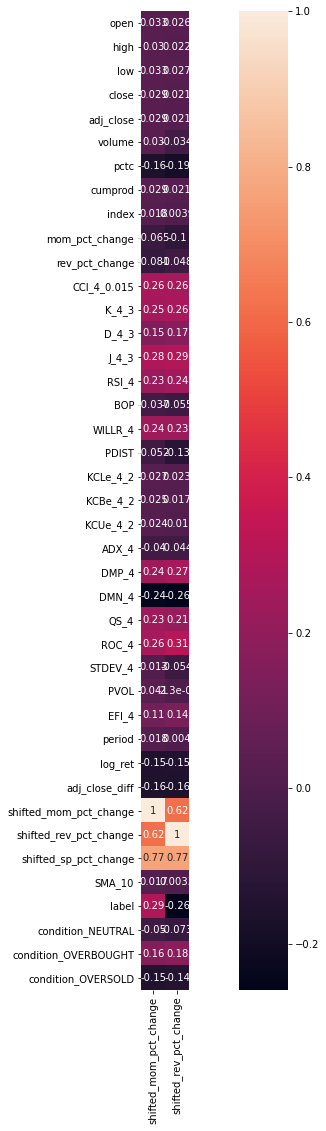

In [86]:
corr = df.corr() 
fig, ax = plt.subplots(figsize = (18, 18)) 
sns.heatmap(corr[['shifted_mom_pct_change','shifted_rev_pct_change']], annot = True,square=True) 

In [53]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'pctc',
       'cumprod', 'index', 'mom_pct_change', 'rev_pct_change', 'CCI_4_0.015',
       'K_4_3', 'D_4_3', 'J_4_3', 'RSI_4', 'BOP', 'WILLR_4', 'PDIST',
       'KCLe_4_2', 'KCBe_4_2', 'KCUe_4_2', 'ADX_4', 'DMP_4', 'DMN_4', 'QS_4',
       'ROC_4', 'STDEV_4', 'PVOL', 'EFI_4', 'log_ret', 'adj_close_diff',
       'shifted_mom_pct_change', 'shifted_rev_pct_change',
       'shifted_sp_pct_change', 'SMA_10', 'label', 'condition_NEUTRAL',
       'condition_OVERBOUGHT', 'condition_OVERSOLD'],
      dtype='object')

In [87]:
correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.90:
            colname = corr.columns[i]
            correlated_features.add(colname)

In [88]:
from sklearn.feature_selection import VarianceThreshold

In [89]:
correlated_features

{'KCBe_4_2',
 'KCLe_4_2',
 'KCUe_4_2',
 'RSI_4',
 'SMA_10',
 'WILLR_4',
 'adj_close',
 'adj_close_diff',
 'close',
 'cumprod',
 'high',
 'index',
 'low',
 'period'}

In [90]:
num_colums = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(df.select_dtypes(include=num_colums).columns)
df = df[numerical_columns]
df

,open,high,low,close,adj_close,volume,pctc,cumprod,index,mom_pct_change,...,log_ret,adj_close_diff,shifted_mom_pct_change,shifted_rev_pct_change,shifted_sp_pct_change,SMA_10,label,condition_NEUTRAL,condition_OVERBOUGHT,condition_OVERSOLD
0,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0.0,0.000000,...,0.000000,3.530029,0.000000,0.000000,0.016043,1136.743994,0,1,0,0
1,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0.0,0.027465,...,0.003111,3.530029,0.000000,0.000000,0.016043,1136.743994,0,0,1,0
2,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0.0,0.023555,...,0.000545,0.619995,0.027465,-0.004083,0.003116,1136.743994,1,0,1,0
3,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0.0,0.073832,...,0.003993,4.549927,0.023555,-0.018759,0.000546,1136.743994,1,0,1,0
4,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0.0,-0.000327,...,0.002878,3.290039,0.073832,-0.004437,0.004001,1136.743994,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,3921.159912,3930.409912,3903.070068,3906.709961,3906.709961,4823940000,-0.001855,279.347483,202.0,0.033294,...,-0.001857,-7.260010,-0.002760,-0.016182,-0.004416,3858.775024,0,1,0,0
1544,3885.550049,3902.919922,3874.709961,3876.500000,3876.500000,5870190000,-0.007733,276.414050,202.0,0.008454,...,-0.007763,-30.209961,0.033294,0.020210,-0.001855,3875.001025,1,0,0,1
1545,3857.070068,3895.979980,3805.590088,3881.370117,3881.370117,6280650000,0.001256,276.886946,202.0,0.006111,...,0.001256,4.870117,0.008454,0.005488,-0.007733,3885.752026,1,0,0,1
1546,3873.709961,3928.649902,3859.600098,3925.429932,3925.429932,5942350000,0.011352,281.165221,202.0,0.009047,...,0.011288,44.059814,0.006111,-0.008144,0.001256,3895.664014,1,1,0,0


In [115]:
df.columns

Index(['open', 'high', 'low', 'close', 'adj_close', 'volume', 'pctc',
       'cumprod', 'index', 'mom_pct_change', 'rev_pct_change', 'CCI_4_0.015',
       'K_4_3', 'D_4_3', 'J_4_3', 'RSI_4', 'BOP', 'WILLR_4', 'PDIST',
       'KCLe_4_2', 'KCBe_4_2', 'KCUe_4_2', 'ADX_4', 'DMP_4', 'DMN_4', 'QS_4',
       'ROC_4', 'STDEV_4', 'PVOL', 'EFI_4', 'period', 'log_ret',
       'adj_close_diff', 'shifted_mom_pct_change', 'shifted_rev_pct_change',
       'shifted_sp_pct_change', 'SMA_10', 'label', 'condition_NEUTRAL',
       'condition_OVERBOUGHT', 'condition_OVERSOLD'],
      dtype='object')

In [100]:
df.reset_index(drop=True,inplace=True)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1), 
                                                    df['label'], train_size=0.33)
X_before = X_test
X_test = X_test.fillna(0)
y_test = y_test.fillna(0)

X_train = X_train.fillna(0)
y_train = y_train.fillna(0)



# removing quasi content fucks the model

constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)

len(X_train.columns[constant_filter.get_support()])

constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant_filter.get_support()]]

X_train.drop(labels=constant_columns, axis=1, inplace=True)
X_test.drop(labels=constant_columns, axis=1, inplace=True)



X_train.drop(columns=correlated_features, axis=1, inplace=True)
X_test.drop(columns=correlated_features, axis=1, inplace=True)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [101]:
constant_columns

['pctc',
 'mom_pct_change',
 'rev_pct_change',
 'log_ret',
 'shifted_mom_pct_change',
 'shifted_rev_pct_change',
 'shifted_sp_pct_change']

In [114]:
X_train.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [102]:
X_before

,open,high,low,close,adj_close,volume,pctc,cumprod,index,mom_pct_change,...,period,log_ret,adj_close_diff,shifted_mom_pct_change,shifted_rev_pct_change,shifted_sp_pct_change,SMA_10,condition_NEUTRAL,condition_OVERBOUGHT,condition_OVERSOLD
373,1429.130005,1437.760010,1429.130005,1433.560059,1433.560059,3509630000,0.003135,39.200863,48.0,-0.001582,...,49,0.003130,4.480103,0.003262,-0.002246,-0.006148,1412.562988,1,0,0
1117,2835.050049,2842.239990,2830.590088,2839.129883,2839.129883,3519650000,0.002174,175.683833,146.0,0.007375,...,147,0.002172,6.159912,0.005538,0.010108,0.008067,2765.332983,0,1,0
1546,3873.709961,3928.649902,3859.600098,3925.429932,3925.429932,5942350000,0.011352,281.165221,202.0,0.009047,...,203,0.011288,44.059814,0.006111,-0.008144,0.001256,3895.664014,1,0,0
417,1461.020020,1472.300049,1461.020020,1472.119995,1472.119995,4081840000,0.007597,42.945092,54.0,0.005051,...,55,0.007569,11.099976,0.004051,0.004981,0.002656,1436.696008,0,1,0
364,1413.089966,1416.119995,1406.780029,1413.489990,1413.489990,3062690000,0.000226,37.252029,47.0,-0.000262,...,48,0.000226,0.319946,-0.001408,0.012857,-0.003498,1396.443994,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,1746.479980,1759.329956,1746.479980,1754.670044,1754.670044,3850840000,0.005738,70.381132,68.0,0.005315,...,69,0.005721,10.010010,-0.002759,-0.008946,0.000092,1715.461023,0,1,0
1353,2918.550049,2948.459961,2917.120117,2938.129883,2938.129883,3217250000,0.006416,185.296883,177.0,0.005257,...,178,0.006395,18.729980,0.000970,0.007187,0.009104,2960.536011,1,0,0
1312,2932.939941,2943.979980,2929.050049,2941.760010,2941.760010,5420700000,0.005757,185.649374,172.0,0.010168,...,173,0.005741,16.840088,0.018666,0.010954,0.003823,2892.819995,1,0,0
1376,3135.360107,3142.120117,3126.090088,3132.520020,3132.520020,3343790000,-0.001097,204.172461,180.0,-0.007317,...,181,-0.001098,-3.439941,-0.004450,-0.006673,-0.003163,3118.024976,1,0,0


In [103]:
X_test

array([[-0.98818918, -0.34838482,  0.26227286, ...,  0.95025527,
        -0.71335527, -0.39886202],
       [ 1.02705781, -0.3382409 ,  0.93057854, ..., -1.05234881,
         1.40182605, -0.39886202],
       [ 2.51587382,  2.11442046,  0.39687552, ...,  0.95025527,
        -0.71335527, -0.39886202],
       ...,
       [ 1.16737327,  1.58631925,  1.36335849, ...,  0.95025527,
        -0.71335527, -0.39886202],
       [ 1.45752251, -0.51627575, -0.12143554, ...,  0.95025527,
        -0.71335527, -0.39886202],
       [-0.39596524,  0.11995637, -1.74291171, ...,  0.95025527,
        -0.71335527, -0.39886202]])

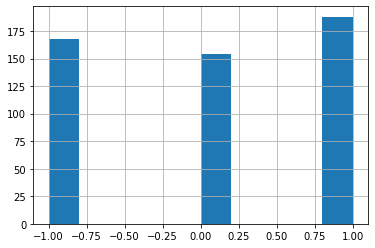

In [104]:
y_train.hist()

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [116]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=True, fit_intercept=True, penalty='l2'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
clf.fit(X_train,y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [117]:
predictions = clf.predict(X_test)
predictions

array([-1,  1,  0, ...,  0,  1,  0])

In [118]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.44      0.29      0.35       375
           0       0.50      0.54      0.52       314
           1       0.38      0.50      0.43       349

    accuracy                           0.43      1038
   macro avg       0.44      0.44      0.43      1038
weighted avg       0.44      0.43      0.43      1038



In [119]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.41176471 0.43137255 0.43137255 0.37254902 0.39215686 0.41176471
 0.39215686 0.41176471 0.56862745 0.39215686]


In [120]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.37254901960784315, 0.4215686274509804, 0.5686274509803921)

In [121]:
X_before.reset_index(drop=True,inplace=True)
X_before

,open,high,low,close,adj_close,volume,pctc,cumprod,index,mom_pct_change,...,period,log_ret,adj_close_diff,shifted_mom_pct_change,shifted_rev_pct_change,shifted_sp_pct_change,SMA_10,condition_NEUTRAL,condition_OVERBOUGHT,condition_OVERSOLD
0,1429.130005,1437.760010,1429.130005,1433.560059,1433.560059,3509630000,0.003135,39.200863,48.0,-0.001582,...,49,0.003130,4.480103,0.003262,-0.002246,-0.006148,1412.562988,1,0,0
1,2835.050049,2842.239990,2830.590088,2839.129883,2839.129883,3519650000,0.002174,175.683833,146.0,0.007375,...,147,0.002172,6.159912,0.005538,0.010108,0.008067,2765.332983,0,1,0
2,3873.709961,3928.649902,3859.600098,3925.429932,3925.429932,5942350000,0.011352,281.165221,202.0,0.009047,...,203,0.011288,44.059814,0.006111,-0.008144,0.001256,3895.664014,1,0,0
3,1461.020020,1472.300049,1461.020020,1472.119995,1472.119995,4081840000,0.007597,42.945092,54.0,0.005051,...,55,0.007569,11.099976,0.004051,0.004981,0.002656,1436.696008,0,1,0
4,1413.089966,1416.119995,1406.780029,1413.489990,1413.489990,3062690000,0.000226,37.252029,47.0,-0.000262,...,48,0.000226,0.319946,-0.001408,0.012857,-0.003498,1396.443994,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,1746.479980,1759.329956,1746.479980,1754.670044,1754.670044,3850840000,0.005738,70.381132,68.0,0.005315,...,69,0.005721,10.010010,-0.002759,-0.008946,0.000092,1715.461023,0,1,0
1034,2918.550049,2948.459961,2917.120117,2938.129883,2938.129883,3217250000,0.006416,185.296883,177.0,0.005257,...,178,0.006395,18.729980,0.000970,0.007187,0.009104,2960.536011,1,0,0
1035,2932.939941,2943.979980,2929.050049,2941.760010,2941.760010,5420700000,0.005757,185.649374,172.0,0.010168,...,173,0.005741,16.840088,0.018666,0.010954,0.003823,2892.819995,1,0,0
1036,3135.360107,3142.120117,3126.090088,3132.520020,3132.520020,3343790000,-0.001097,204.172461,180.0,-0.007317,...,181,-0.001098,-3.439941,-0.004450,-0.006673,-0.003163,3118.024976,1,0,0


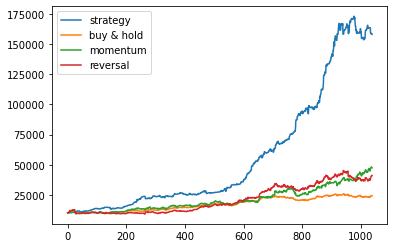

In [112]:
nav = 10000
running_nav = [nav]
running_sp_500 = [nav]
running_momentum = [nav]
running_reversal = [nav]

for index,row in X_before.iterrows():
    running_sp_500.append(running_sp_500[-1] + (running_sp_500[-1]*row['pctc']))
    running_reversal.append(running_reversal[-1] + (running_reversal[-1]*row['rev_pct_change']))
    running_momentum.append(running_momentum[-1] + (running_momentum[-1]*row['mom_pct_change']))
    if(predictions[index] == 1):
        running_nav.append(running_nav[-1] + (running_nav[-1]*(row['shifted_mom_pct_change'])))
    elif(predictions[index] == -1):
        running_nav.append(running_nav[-1] + (running_nav[-1]*(row['shifted_rev_pct_change'])))
    else:
        running_nav.append(running_nav[-1])

plt.plot(running_nav)
plt.plot(running_sp_500)
plt.plot(running_momentum)
plt.plot(running_reversal)
plt.legend(['strategy','buy & hold', 'momentum','reversal'])

plt.savefig('strategy.png')